In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

=== Quick EDA ===
Class Distribution:
StressLevel
Low       0.596128
Medium    0.307639
High      0.096233
Name: proportion, dtype: float64

Correlation Matrix (Numerical Features):


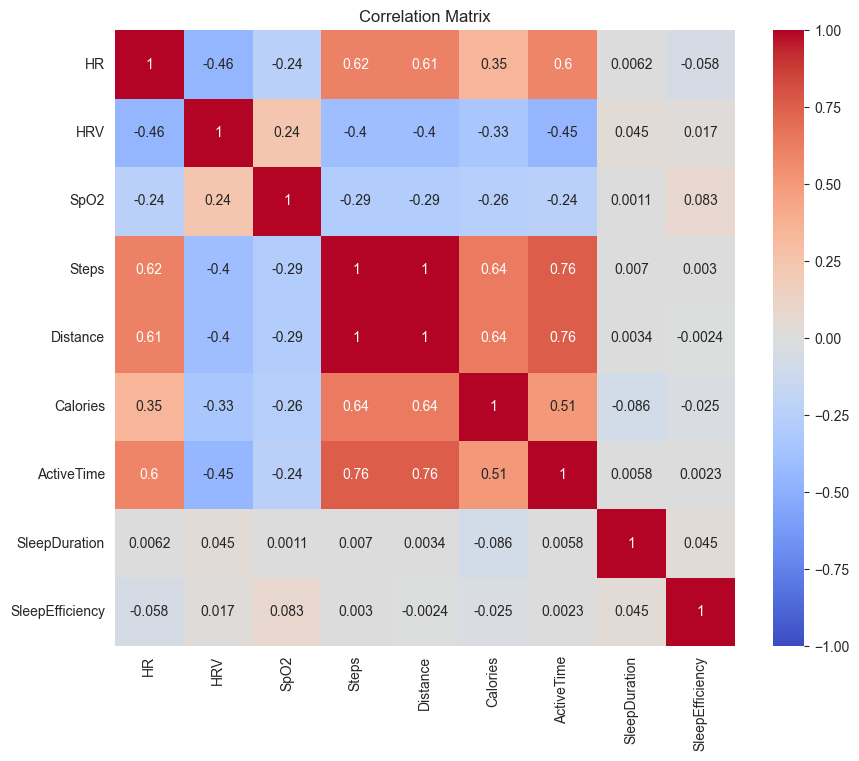

In [2]:
# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
df = pd.read_csv('final_synthetic_stress_dataset.csv')

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 1: Quick EDA to Diagnose Issues
print("=== Quick EDA ===")
print("Class Distribution:")
print(df['StressLevel'].value_counts(normalize=True))
print("\nCorrelation Matrix (Numerical Features):")
numerical_cols = ['HR', 'HRV', 'SpO2', 'Steps', 'Distance', 'Calories', 'ActiveTime', 'SleepDuration', 'SleepEfficiency']
corr = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix_eda.png')
plt.show()


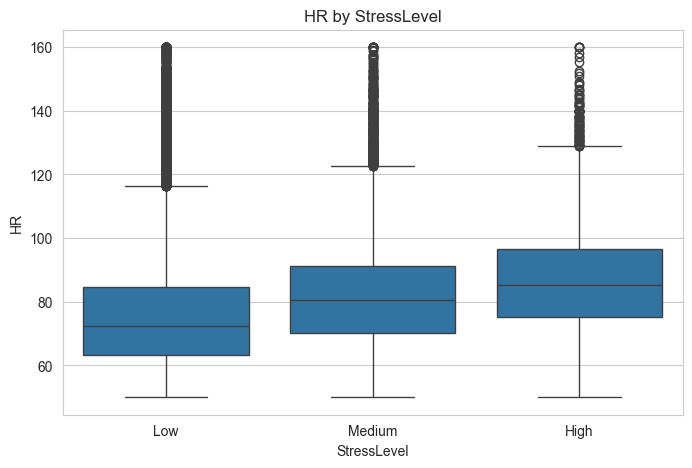

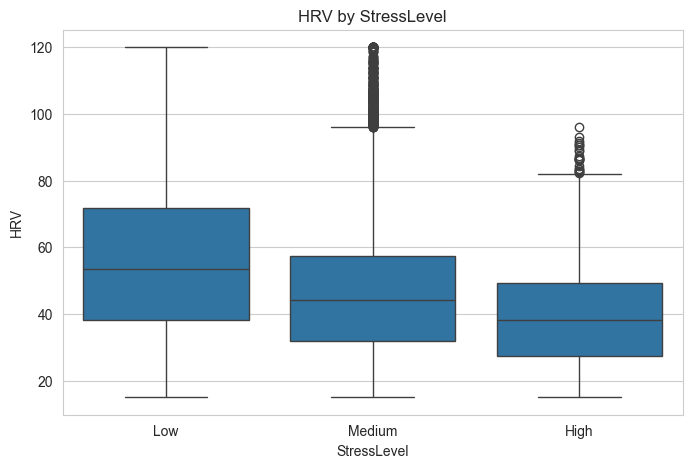

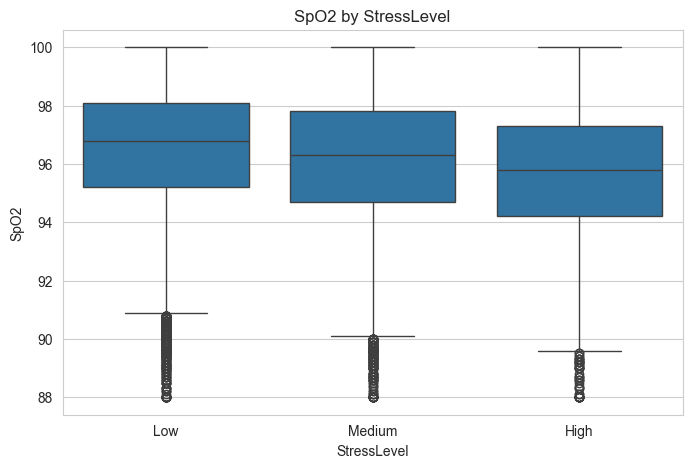

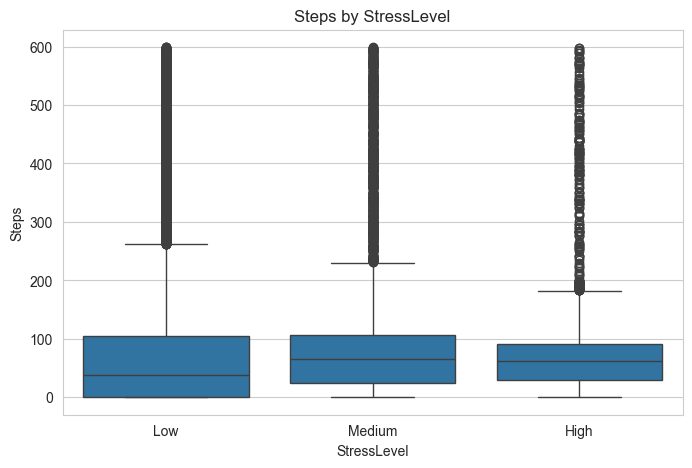

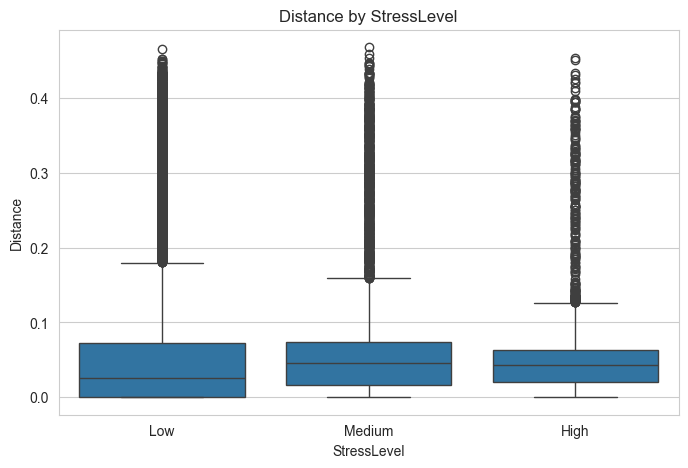

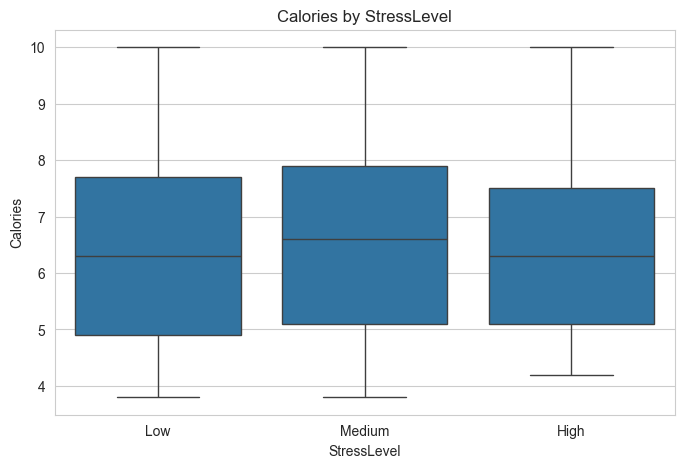

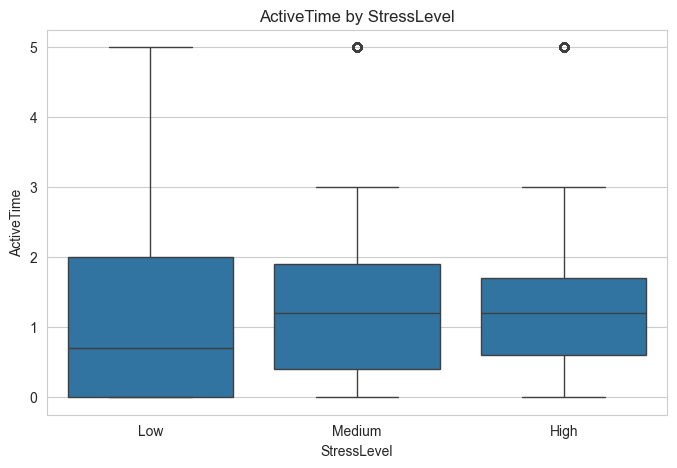

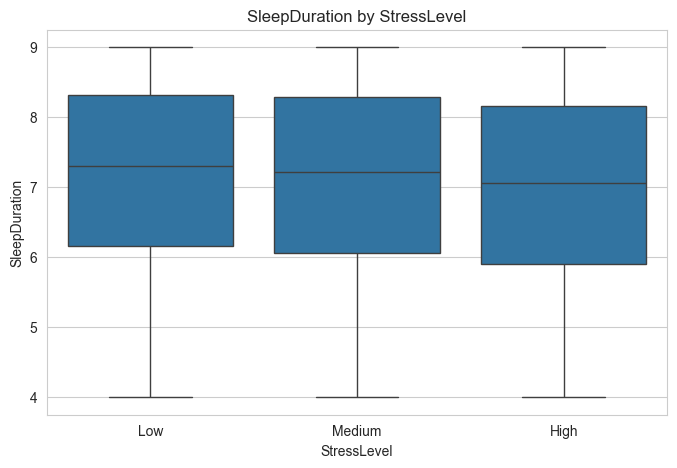

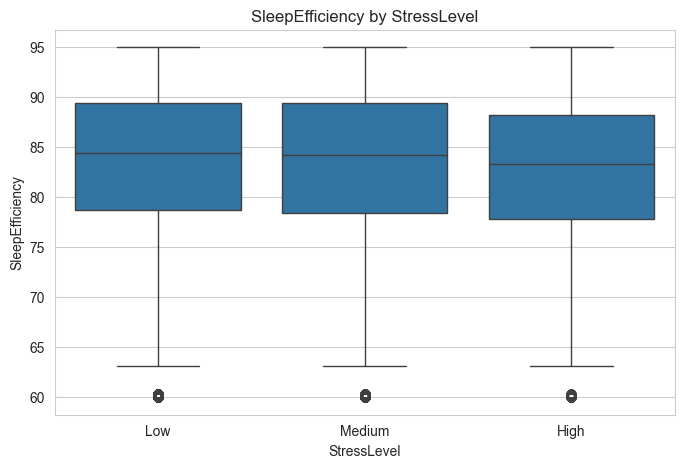

In [3]:

# Check feature distributions by StressLevel
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='StressLevel', y=col)
    plt.title(f'{col} by StressLevel')
    plt.savefig(f'distribution_{col}_by_stress.png')
    plt.show()

# Step 2: Feature Engineering
# Temporal Features
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek  # Monday=0, Sunday=6
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)  # Saturday, Sunday
df['TimeOfDay'] = pd.cut(df['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True)


In [4]:

# Physiological Variability (Rolling Statistics)
window = 6  # 30-minute window (6 * 5-minute intervals)
for col in ['HR', 'HRV', 'SpO2']:
    df[f'{col}_RollingMean'] = df.groupby('UserID')[col].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    df[f'{col}_RollingStd'] = df.groupby('UserID')[col].rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True)

# Interaction Features
df['HR_Steps_Interaction'] = df['HR'] * df['Steps']
df['HRV_SleepDuration_Interaction'] = df['HRV'] * df['SleepDuration']

# Activity Intensity
df['ActivityIntensity'] = pd.cut(df['Steps'], bins=[-1, 100, 400, 600], labels=['Low', 'Moderate', 'High'], include_lowest=True)

# Fill any NaNs from rolling calculations
df.fillna(df.mean(numeric_only=True), inplace=True)

# Step 3: Data Preprocessing
# Define features and target
target = 'StressLevel'
features = ['HR', 'HRV', 'SpO2', 'Steps', 'Distance', 'Calories', 'ActiveTime', 'SleepDuration', 'SleepEfficiency',
            'Age', 'Sex', 'DrinkingHabits', 'SmokingHabits', 'PastMedicalHistory', 'Depression', 'Context',
            'Hour', 'DayOfWeek', 'IsWeekend', 'TimeOfDay', 'HR_RollingMean', 'HR_RollingStd', 'HRV_RollingMean',
            'HRV_RollingStd', 'SpO2_RollingMean', 'SpO2_RollingStd', 'HR_Steps_Interaction',
            'HRV_SleepDuration_Interaction', 'ActivityIntensity']

X = df[features]
y = df[target]

In [5]:

# Encode categorical variables
categorical_cols = ['Sex', 'DrinkingHabits', 'SmokingHabits', 'PastMedicalHistory', 'Depression', 'Context', 'TimeOfDay', 'ActivityIntensity']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Scale numerical features
numerical_cols = [col for col in X.columns if col not in categorical_cols]
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Apply PCA to numerical features
pca = PCA(n_components=0.95)  # Retain 95% variance
X_numerical = X[numerical_cols]
X_pca = pca.fit_transform(X_numerical)
print(f"PCA: {X_pca.shape[1]} components explain 95% of variance")
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

PCA: 14 components explain 95% of variance


In [6]:
# Combine PCA components with categorical features
X_final = pd.concat([X_pca_df, X[categorical_cols].reset_index(drop=True)], axis=1)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_final, y)
print("Class Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True))


Class Distribution After SMOTE:
1    0.333333
2    0.333333
0    0.333333
Name: proportion, dtype: float64


In [7]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Step 4: Model Training and Evaluation
models = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    # 'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# Dictionary to store results
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], 'ROC-AUC': [], 'CV Score': []}



=== Logistic Regression ===
Accuracy: 0.5302
ROC-AUC: 0.7088
Cross-Validation Accuracy: 0.5296 (±0.0092)

Classification Report:
              precision    recall  f1-score   support

        High       0.58      0.66      0.61      6867
         Low       0.58      0.63      0.60      6868
      Medium       0.39      0.30      0.34      6868

    accuracy                           0.53     20603
   macro avg       0.52      0.53      0.52     20603
weighted avg       0.52      0.53      0.52     20603



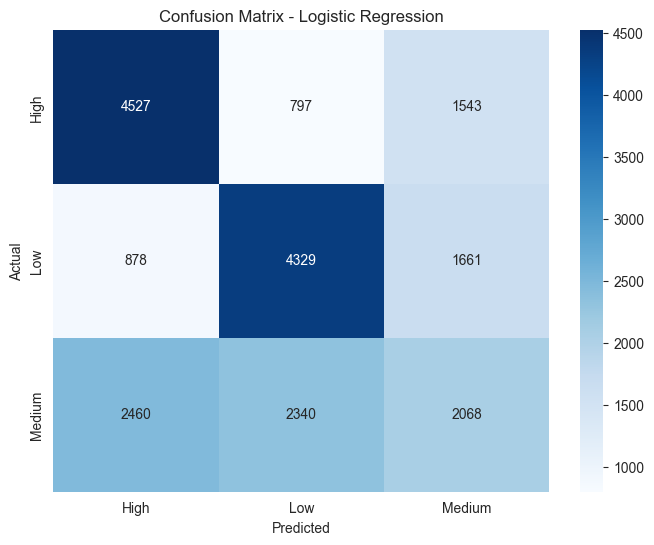


=== Random Forest ===
Accuracy: 0.8020
ROC-AUC: 0.9295
Cross-Validation Accuracy: 0.7764 (±0.0033)

Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.96      0.90      6867
         Low       0.78      0.75      0.76      6868
      Medium       0.77      0.69      0.73      6868

    accuracy                           0.80     20603
   macro avg       0.80      0.80      0.80     20603
weighted avg       0.80      0.80      0.80     20603



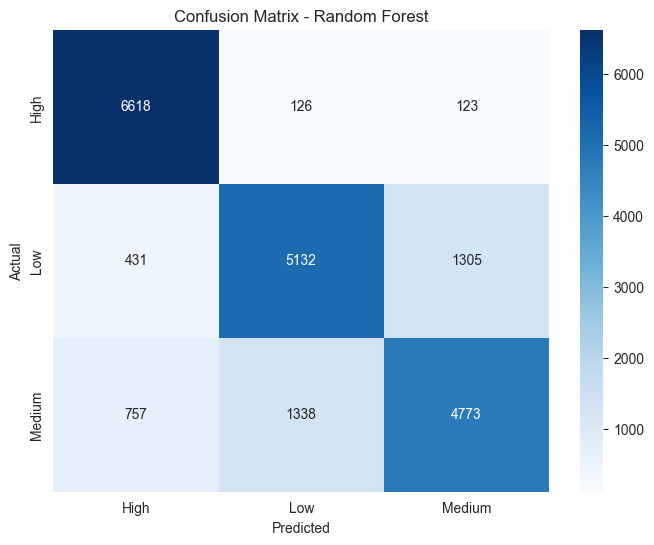


=== XGBoost ===
Accuracy: 0.6570
ROC-AUC: 0.8287
Cross-Validation Accuracy: 0.6487 (±0.0073)

Classification Report:
              precision    recall  f1-score   support

        High       0.68      0.86      0.76      6867
         Low       0.68      0.67      0.68      6868
      Medium       0.59      0.43      0.50      6868

    accuracy                           0.66     20603
   macro avg       0.65      0.66      0.65     20603
weighted avg       0.65      0.66      0.65     20603



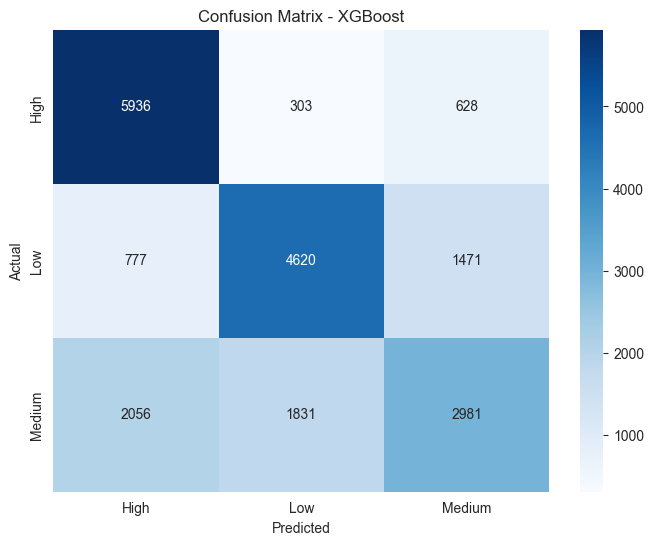

In [8]:

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.show()

# Train and evaluate each model
for model_name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le_target.classes_, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    # ROC-AUC (one-vs-rest)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        roc_auc = np.nan

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()

    # Store results
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1'].append(f1)
    results['ROC-AUC'].append(roc_auc)
    results['CV Score'].append(cv_mean)

    # Print results
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}" if not np.isnan(roc_auc) else "ROC-AUC: Not available")
    print(f"Cross-Validation Accuracy: {cv_mean:.4f} (±{cv_scores.std() * 2:.4f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, model_name)


=== Model Comparison ===
                 Model  Accuracy  Precision    Recall        F1   ROC-AUC  \
0  Logistic Regression  0.530214   0.515890  0.530214  0.519759  0.708818   
1        Random Forest  0.801971   0.798521  0.801971  0.798270  0.929478   
2              XGBoost  0.657040   0.649259  0.657040  0.645522  0.828694   

   CV Score  
0  0.529560  
1  0.776417  
2  0.648723  


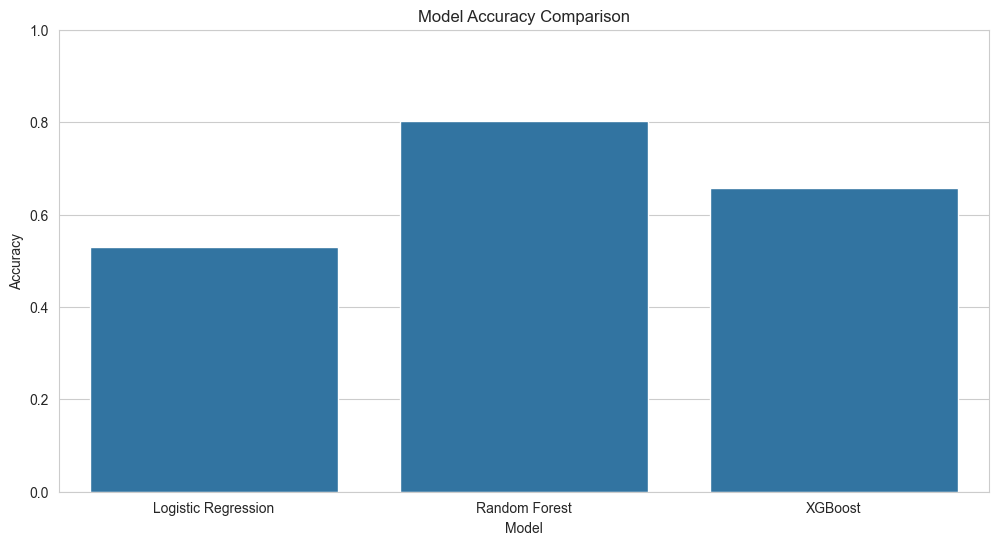

In [9]:
# Step 5: Model Comparison
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)
results_df.to_csv('model_comparison_enhanced.csv', index=False)

# Visualize model performance
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.savefig('model_accuracy_comparison_enhanced.png')
plt.show()


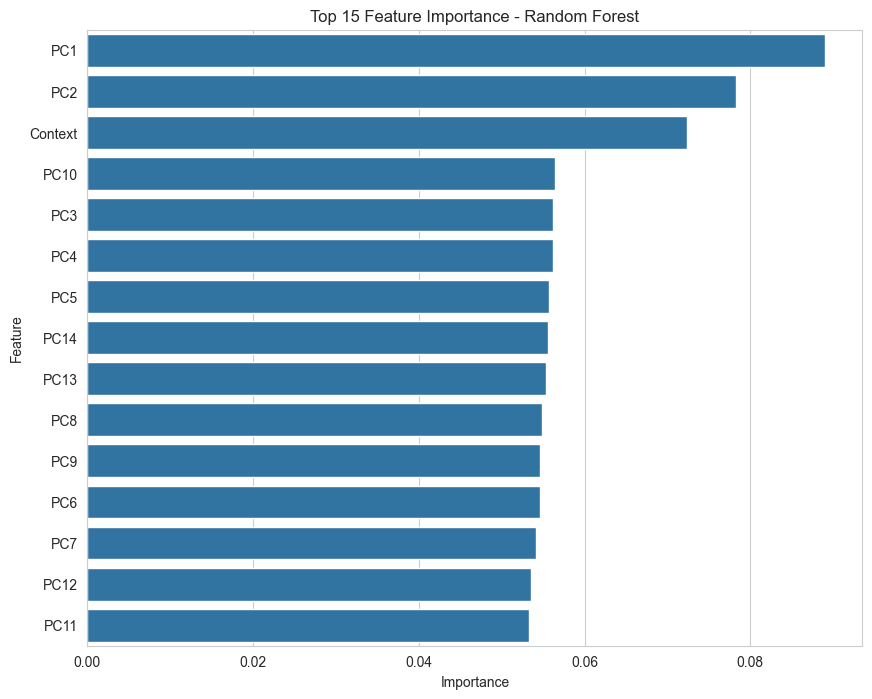

In [11]:


# Step 6: Feature Importance (Random Forest and XGBoost)
# Random Forest
rf_model = models['Random Forest']
feature_importance_rf = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_rf.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importance - Random Forest')
# plt.savefig('feature_importance_rf_enhanced.png')
plt.show()


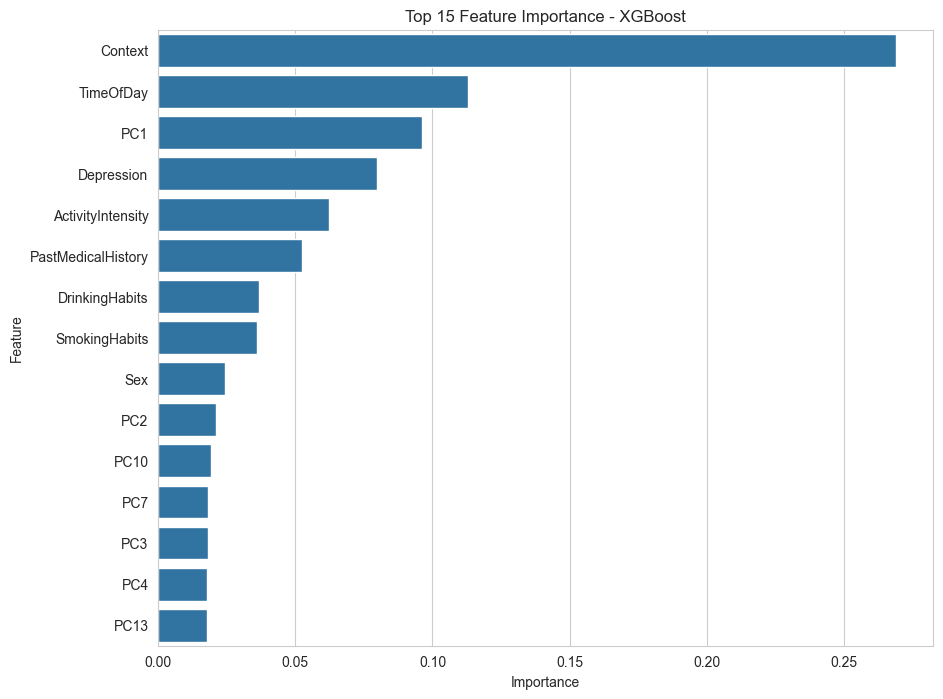

In [12]:
# XGBoost
xgb_model = models['XGBoost']
feature_importance_xgb = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_xgb.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importance - XGBoost')
# plt.savefig('feature_importance_xgb_enhanced.png')
plt.show()

In [13]:
# Step 7: Hyperparameter Tuning (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n=== Random Forest Hyperparameter Tuning ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")



=== Random Forest Hyperparameter Tuning ===
Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation F1-Score: 0.7774



Best Random Forest Performance:
Test Accuracy: 0.8057
ROC-AUC: 0.9319

Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.97      0.90      6867
         Low       0.78      0.75      0.76      6868
      Medium       0.78      0.70      0.74      6868

    accuracy                           0.81     20603
   macro avg       0.80      0.81      0.80     20603
weighted avg       0.80      0.81      0.80     20603



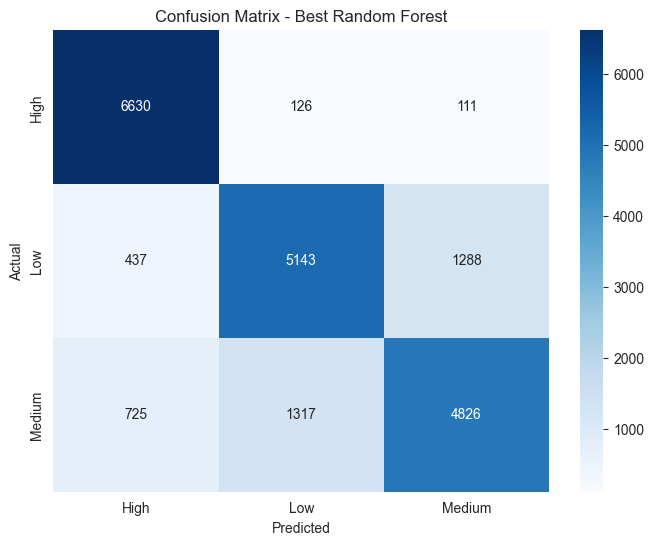


Enhanced ML Modeling Completed. Results and visualizations saved.


In [14]:

# Evaluate best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("\nBest Random Forest Performance:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test), multi_class='ovr'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=le_target.classes_))
plot_confusion_matrix(y_test, y_pred_best, 'Best Random Forest')

# Save feature importance for best model
feature_importance_best_rf = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)
feature_importance_best_rf.to_csv('feature_importance_best_rf_enhanced.csv', index=False)

print("\nEnhanced ML Modeling Completed. Results and visualizations saved.")

## NN


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
df = pd.read_csv('final_synthetic_stress_dataset.csv')

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [17]:

# Step 1: Feature Engineering
# Temporal Features
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['TimeOfDay'] = pd.cut(df['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True)


In [18]:

# Physiological Variability
window = 6  # 30-minute window
for col in ['HR', 'HRV', 'SpO2']:
    df[f'{col}_RollingMean'] = df.groupby('UserID')[col].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    df[f'{col}_RollingStd'] = df.groupby('UserID')[col].rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True)

# Interaction Features
df['HR_Steps_Interaction'] = df['HR'] * df['Steps']
df['HRV_SleepDuration_Interaction'] = df['HRV'] * df['SleepDuration']

# Activity Intensity
df['ActivityIntensity'] = pd.cut(df['Steps'], bins=[-1, 100, 400, 600], labels=['Low', 'Moderate', 'High'], include_lowest=True)

# Fill NaNs
df.fillna(df.mean(numeric_only=True), inplace=True)

In [19]:


# Step 2: Data Preprocessing
# Define features and target
target = 'StressLevel'
features = ['HR', 'HRV', 'SpO2', 'Steps', 'Distance', 'Calories', 'ActiveTime', 'SleepDuration', 'SleepEfficiency',
            'Age', 'Sex', 'DrinkingHabits', 'SmokingHabits', 'PastMedicalHistory', 'Depression', 'Context',
            'Hour', 'DayOfWeek', 'IsWeekend', 'TimeOfDay', 'HR_RollingMean', 'HR_RollingStd', 'HRV_RollingMean',
            'HRV_RollingStd', 'SpO2_RollingMean', 'SpO2_RollingStd', 'HR_Steps_Interaction',
            'HRV_SleepDuration_Interaction', 'ActivityIntensity']

X = df[features]
y = df[target]

# Encode categorical variables
categorical_cols = ['Sex', 'DrinkingHabits', 'SmokingHabits', 'PastMedicalHistory', 'Depression', 'Context', 'TimeOfDay', 'ActivityIntensity']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode target variable
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Scale numerical features
numerical_cols = [col for col in X.columns if col not in categorical_cols]
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Apply PCA to numerical features
pca = PCA(n_components=0.95)
X_numerical = X[numerical_cols]
X_pca = pca.fit_transform(X_numerical)
print(f"PCA: {X_pca.shape[1]} components explain 95% of variance")
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Combine PCA components with categorical features
X_final = pd.concat([X_pca_df, X[categorical_cols].reset_index(drop=True)], axis=1)


PCA: 14 components explain 95% of variance


In [20]:

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_final, y)
print("Class Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True))


Class Distribution After SMOTE:
1    0.333333
2    0.333333
0    0.333333
Name: proportion, dtype: float64


In [21]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# One-hot encode target for neural networks
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Step 3: Prepare Time-Series Data for RNN/LSTM
def create_sequences(X, y, time_steps=6):
    Xs, ys = [], []
    for user in df['UserID'].unique():
        user_data = X[df['UserID'] == user].values
        user_labels = y[df['UserID'] == user]
        for i in range(len(user_data) - time_steps):
            Xs.append(user_data[i:(i + time_steps)])
            ys.append(user_labels[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 6  # 30-minute sequences
X_seq, y_seq = create_sequences(X_final, y, time_steps)
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
y_seq_train_cat = to_categorical(y_seq_train)
y_seq_test_cat = to_categorical(y_seq_test)


In [22]:

# Step 4: Neural Network Models
# ANN
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ann_history = ann_model.fit(X_train, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test, y_test_cat), verbose=1)

Epoch 1/20
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4975 - loss: 0.9812 - val_accuracy: 0.5476 - val_loss: 0.8949
Epoch 2/20
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - accuracy: 0.5448 - loss: 0.9044 - val_accuracy: 0.5586 - val_loss: 0.8843
Epoch 3/20
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5518 - loss: 0.8885 - val_accuracy: 0.5624 - val_loss: 0.8734
Epoch 4/20
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5574 - loss: 0.8775 - val_accuracy: 0.5689 - val_loss: 0.8672
Epoch 5/20
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 2s 856us/step - accuracy: 0.5587 - loss: 0.8773 - val_accuracy: 0.5666 - val_loss: 0.8637
Epoch 6/20
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 2s 942us/step - accuracy: 0.5635 - loss: 0.8703 - val_accuracy: 0.5700 - val_loss: 0.8607
Epoch 7/20
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 2s 833us/step - accuracy: 0.5670 - loss: 0.8671 - val_accuracy: 0.5705 - val_loss: 0.8555
Epoch 8/20
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step - accuracy: 0.5631 - loss:

In [23]:


# RNN
rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(time_steps, X_seq_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(20, activation='relu'),
    Dense(3, activation='softmax')
])
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(X_seq_train, y_seq_train_cat, epochs=10, batch_size=32, validation_data=(X_seq_test, y_seq_test_cat), verbose=1)


Epoch 1/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5868 - loss: 0.8696 - val_accuracy: 0.6368 - val_loss: 0.7931
Epoch 2/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6331 - loss: 0.8009 - val_accuracy: 0.6385 - val_loss: 0.7927
Epoch 3/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6395 - loss: 0.7943 - val_accuracy: 0.6399 - val_loss: 0.7875
Epoch 4/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6395 - loss: 0.7898 - val_accuracy: 0.6408 - val_loss: 0.7847
Epoch 5/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6386 - loss: 0.7880 - val_accuracy: 0.6408 - val_loss: 0.7837
Epoch 6/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6398 - loss: 0.7878 - val_accuracy: 0.6427 - val_loss: 0.7822
Epoch 7/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6405 - loss: 0.7855 - val_accuracy: 0.6431 - val_loss: 0.7828
Epoch 8/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6350 - loss: 0.7901 - 

In [24]:

# LSTM
lstm_model = Sequential([
    LSTM(50, activation='tanh', input_shape=(time_steps, X_seq_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(20, activation='relu'),
    Dense(3, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_seq_train, y_seq_train_cat, epochs=10, batch_size=32, validation_data=(X_seq_test, y_seq_test_cat), verbose=1)

Epoch 1/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6230 - loss: 0.8210 - val_accuracy: 0.6412 - val_loss: 0.7873
Epoch 2/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6341 - loss: 0.7955 - val_accuracy: 0.6411 - val_loss: 0.7864
Epoch 3/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6418 - loss: 0.7874 - val_accuracy: 0.6427 - val_loss: 0.7827
Epoch 4/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6384 - loss: 0.7891 - val_accuracy: 0.6431 - val_loss: 0.7828
Epoch 5/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6362 - loss: 0.7885 - val_accuracy: 0.6420 - val_loss: 0.7828
Epoch 6/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6349 - loss: 0.7876 - val_accuracy: 0.6430 - val_loss: 0.7815
Epoch 7/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6431 - loss: 0.7792 - val_accuracy: 0.6435 - val_loss: 0.7821
Epoch 8/10
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6399 - loss: 0.7837 - 

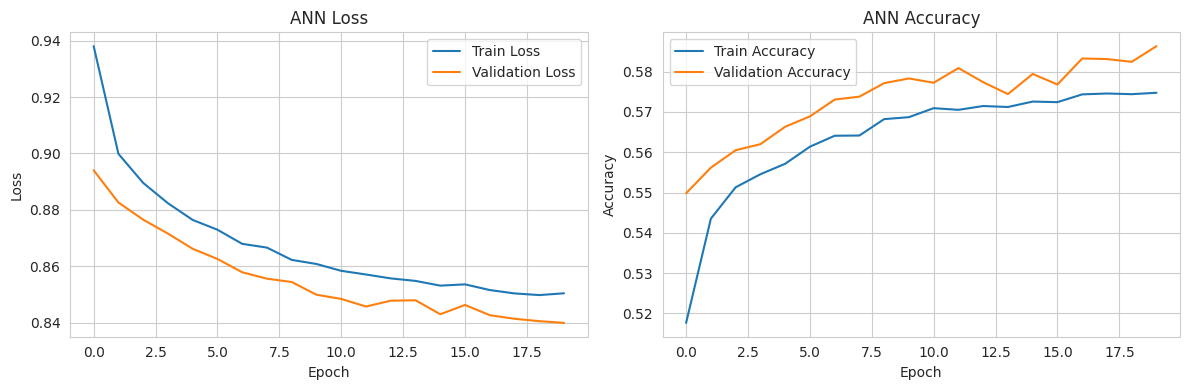

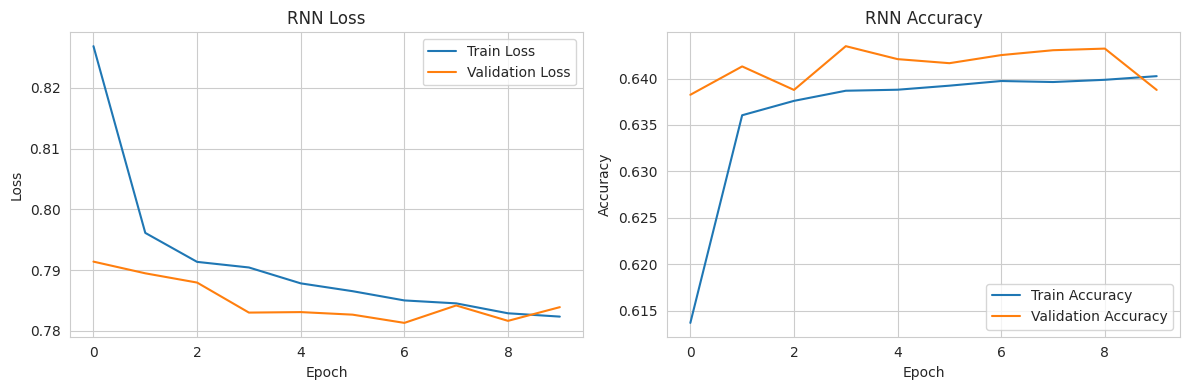

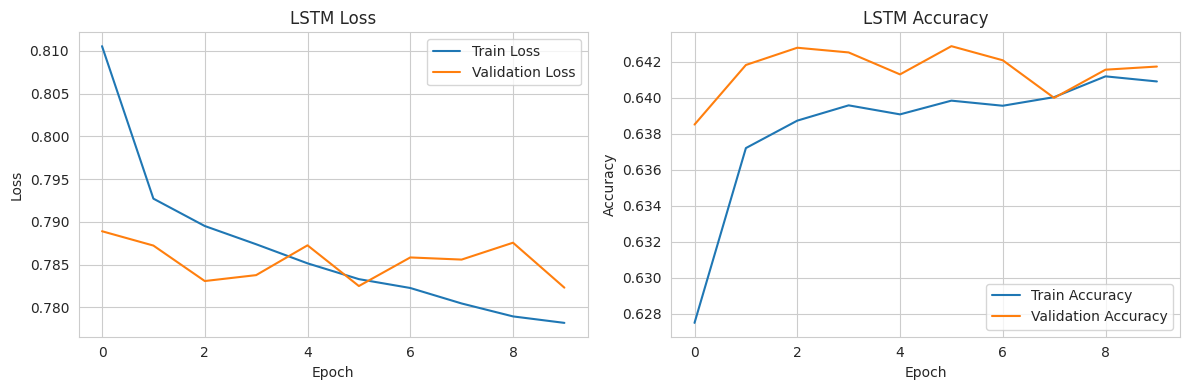

In [ ]:
# # Plot training history
# def plot_history(history, model_name):
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title(f'{model_name} Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title(f'{model_name} Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.tight_layout()
#     # plt.savefig(f'training_history_{model_name.lower().replace(" ", "_")}.png')
#     plt.show()

# plot_history(ann_history, 'ANN')
# plot_history(rnn_history, 'RNN')
# plot_history(lstm_history, 'LSTM')

In [25]:
# Step 5: Ensemble Methods
# Base models for ensemble
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('ann', LogisticRegression(multi_class='multinomial', max_iter=1000))  # Proxy for ANN
], voting='soft')
voting_clf.fit(X_train, y_train)

# Stacking Classifier
from sklearn.ensemble import StackingClassifier
stacking_clf = StackingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('ann', LogisticRegression(multi_class='multinomial', max_iter=1000))
], final_estimator=LogisticRegression(multi_class='multinomial', max_iter=1000))
stacking_clf.fit(X_train, y_train)


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              gr...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('ann',
                                LogisticRegression(max_iter=1000,
                                                   multi_class='multinomial'))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      multi_class='multinomial'))

In [26]:
# Step 5: Ensemble Methods
# Base models for ensemble
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# Stacking Classifier
from sklearn.ensemble import StackingClassifier
stacking_clf_2 = StackingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('ann', LogisticRegression(multi_class='multinomial', max_iter=1000))
], final_estimator=rf_model)
stacking_clf_2.fit(X_train, y_train)


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              gr...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('ann',
                                LogisticRegression(max_iter=1000,
                                                   multi_class='multinomial'))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [27]:
# Step 6: Model Evaluation
models = {
    'ANN': (ann_model, X_test, y_test_cat),
    'RNN': (rnn_model, X_seq_test, y_seq_test_cat),
    'LSTM': (lstm_model, X_seq_test, y_seq_test_cat),
    'Voting Ensemble': (voting_clf, X_test, y_test),
    'Stacking Ensemble': (stacking_clf, X_test, y_test),
    'Stacking Ensemble 2': (stacking_clf_2, X_test, y_test)
}

results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], 'ROC-AUC': []}


644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step

=== ANN ===
Accuracy: 0.5839
ROC-AUC: 0.7686

Classification Report:
              precision    recall  f1-score   support

        High       0.58      0.84      0.69      6867
         Low       0.64      0.67      0.66      6868
      Medium       0.48      0.24      0.32      6868

    accuracy                           0.58     20603
   macro avg       0.57      0.58      0.55     20603
weighted avg       0.57      0.58      0.55     20603



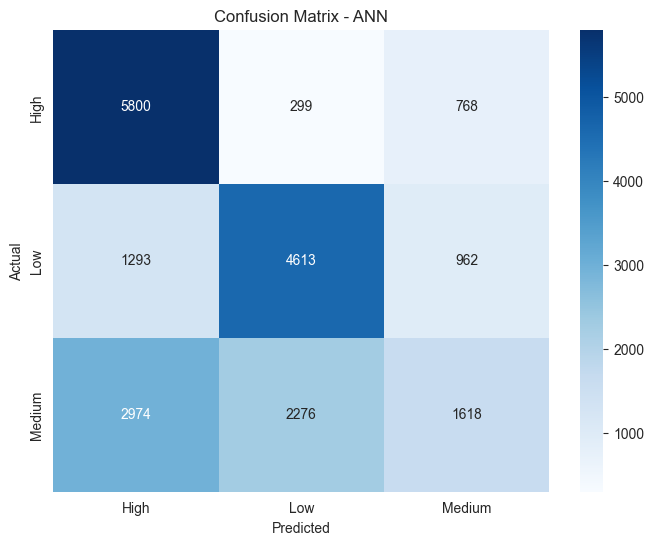

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step

=== RNN ===
Accuracy: 0.6428
ROC-AUC: 0.7258

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00      1133
         Low       0.69      0.91      0.79      6910
      Medium       0.46      0.31      0.37      3429

    accuracy                           0.64     11472
   macro avg       0.38      0.41      0.39     11472
weighted avg       0.55      0.64      0.58     11472



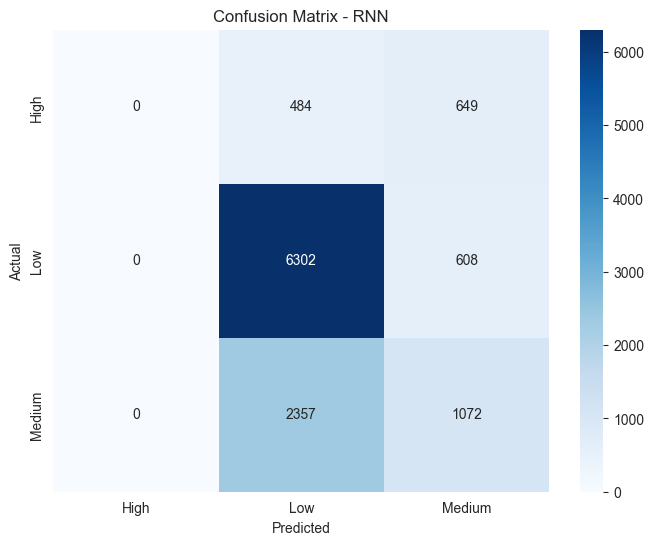

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step

=== LSTM ===
Accuracy: 0.6435
ROC-AUC: 0.7234

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00      1133
         Low       0.69      0.92      0.79      6910
      Medium       0.47      0.31      0.37      3429

    accuracy                           0.64     11472
   macro avg       0.38      0.41      0.39     11472
weighted avg       0.55      0.64      0.58     11472



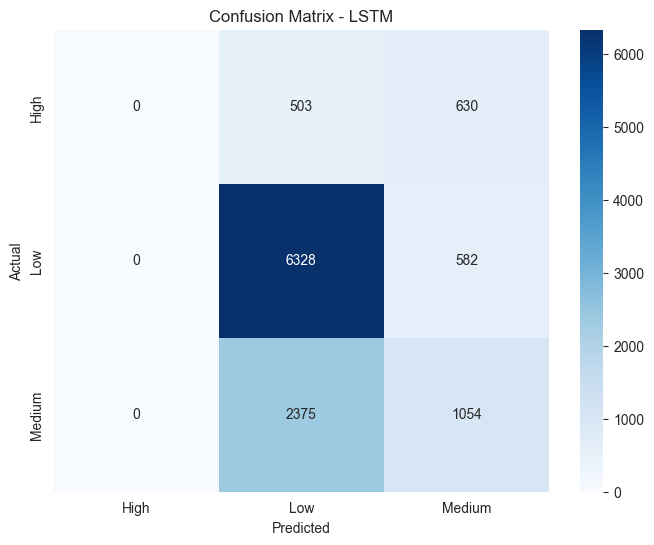


=== Voting Ensemble ===
Accuracy: 0.7229
ROC-AUC: 0.8836

Classification Report:
              precision    recall  f1-score   support

        High       0.74      0.92      0.82      6867
         Low       0.73      0.72      0.73      6868
      Medium       0.69      0.53      0.60      6868

    accuracy                           0.72     20603
   macro avg       0.72      0.72      0.71     20603
weighted avg       0.72      0.72      0.71     20603



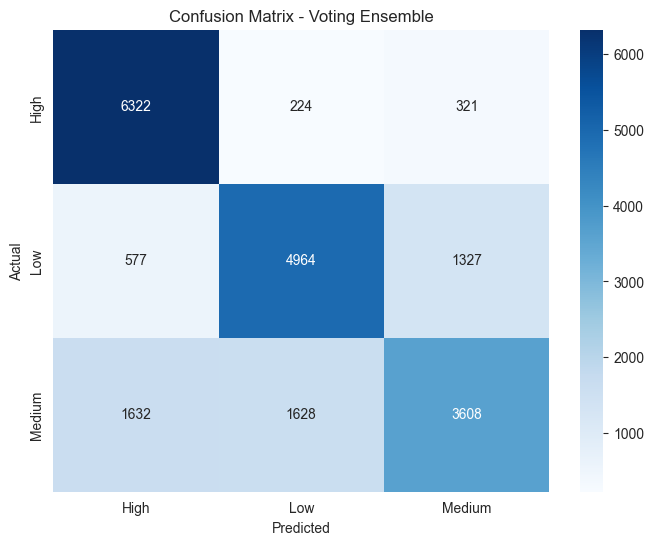


=== Stacking Ensemble ===
Accuracy: 0.8180
ROC-AUC: 0.9413

Classification Report:
              precision    recall  f1-score   support

        High       0.92      0.94      0.93      6867
         Low       0.77      0.76      0.77      6868
      Medium       0.76      0.75      0.76      6868

    accuracy                           0.82     20603
   macro avg       0.82      0.82      0.82     20603
weighted avg       0.82      0.82      0.82     20603



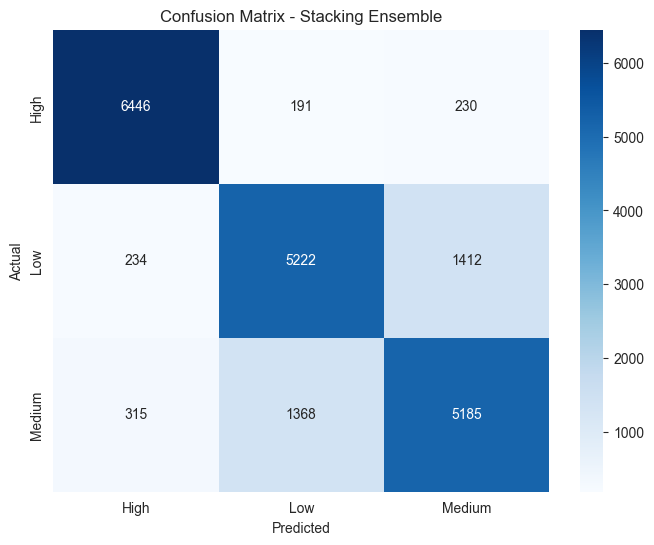


=== Stacking Ensemble 2 ===
Accuracy: 0.8136
ROC-AUC: 0.9370

Classification Report:
              precision    recall  f1-score   support

        High       0.92      0.94      0.93      6867
         Low       0.75      0.79      0.77      6868
      Medium       0.77      0.72      0.74      6868

    accuracy                           0.81     20603
   macro avg       0.81      0.81      0.81     20603
weighted avg       0.81      0.81      0.81     20603



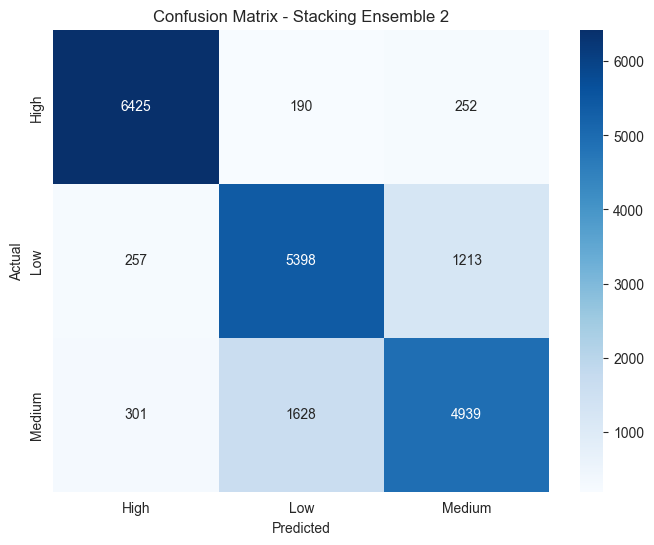

In [28]:

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.show()

for model_name, (model, X_eval, y_eval) in models.items():
    if model_name in ['ANN', 'RNN', 'LSTM']:
        y_pred = model.predict(X_eval)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_eval, axis=1)
        if model_name == 'ANN':
            y_proba = model.predict(X_eval)
        else:
            y_proba = model.predict(X_eval)
    else:
        y_pred = model.predict(X_eval)
        y_true = y_eval
        y_proba = model.predict_proba(X_eval)

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=le_target.classes_, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    roc_auc = roc_auc_score(y_eval if model_name in ['Voting Ensemble', 'Stacking Ensemble'] else to_categorical(y_true), y_proba, multi_class='ovr')

    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1'].append(f1)
    results['ROC-AUC'].append(roc_auc)

    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le_target.classes_))
    plot_confusion_matrix(y_true, y_pred, model_name)




=== Model Comparison ===
                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0                  ANN  0.583944   0.567059  0.583944  0.552709  0.768647
1                  RNN  0.642782   0.552752  0.642782  0.584220  0.725796
2                 LSTM  0.643480   0.553063  0.643480  0.583657  0.723429
3      Voting Ensemble  0.722904   0.718600  0.722904  0.713944  0.883599
4    Stacking Ensemble  0.817988   0.817026  0.817988  0.817468  0.941280
5  Stacking Ensemble 2  0.813571   0.813124  0.813571  0.812866  0.936998


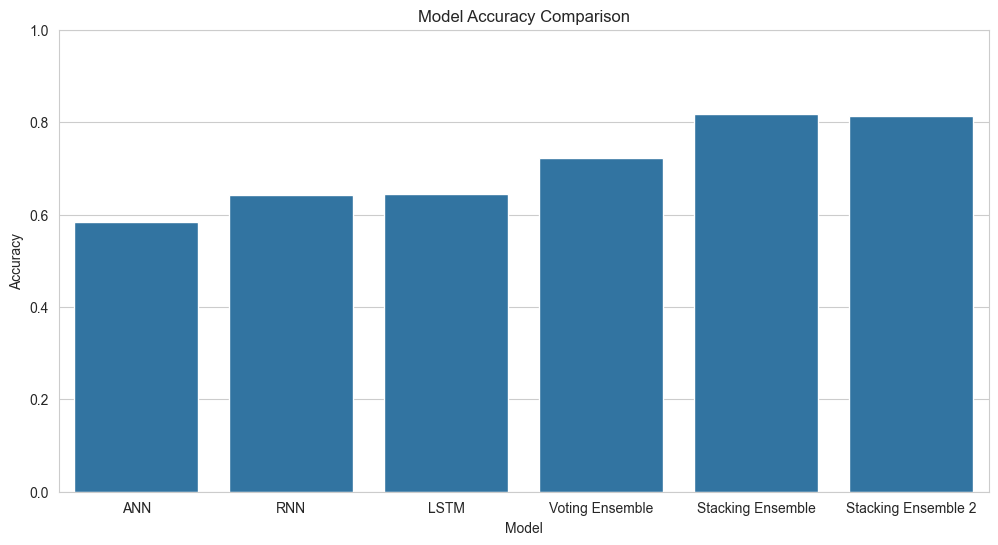

In [29]:
# Step 7: Model Comparison
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)
results_df.to_csv('model_comparison_nn_ensemble.csv', index=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.savefig('model_accuracy_comparison_nn_ensemble.png')
plt.show()



In [30]:
# # Step 8: Feature Importance (Voting Ensemble - Random Forest Component)
# feature_importance_rf = pd.DataFrame({
#     'Feature': X_final.columns,
#     'Importance': models['Voting Ensemble'][0].named_estimators_['rf'].feature_importances_
# }).sort_values('Importance', ascending=False)

# plt.figure(figsize=(10, 8))
# sns.barplot(data=feature_importance_rf.head(15), x='Importance', y='Feature')
# plt.title('Top 15 Feature Importance - Voting Ensemble (Random Forest)')
# plt.savefig('feature_importance_voting_rf.png')
# plt.show()

# print("\nNeural Network and Ensemble Modeling Completed. Results and visualizations saved.")

In [ ]:
# new_data = df.sample(frac=0.1, random_state=123).reset_index(drop=True)
# X_new = new_data[features]
# y_new = new_data[target]

# # Preprocess new data
# for col in categorical_cols:
#     X_new[col] = label_encoders[col].transform(X_new[col])
# X_new[numerical_cols] = scaler.transform(X_new[numerical_cols])
# X_new_pca = pca.transform(X_new[numerical_cols])
# X_new_pca_df = pd.DataFrame(X_new_pca, columns=[f'PC{i+1}' for i in range(X_new_pca.shape[1])])
# X_new_final = pd.concat([X_new_pca_df, X_new[categorical_cols].reset_index(drop=True)], axis=1)
# y_new = le_target.transform(y_new)

# # Predict on new data
# y_new_pred = stacking_clf.predict(X_new_final)
# y_new_proba = stacking_clf.predict_proba(X_new_final)

# # Evaluate on new data
# accuracy_new = accuracy_score(y_new, y_new_pred)
# report_new = classification_report(y_new, y_new_pred, target_names=le_target.classes_, output_dict=True)
# print("\n=== Stacking Classifier on New Data ===")
# print(f"Accuracy: {accuracy_new:.4f}")
# print(f"Precision: {report_new['weighted avg']['precision']:.4f}")
# print(f"Recall: {report_new['weighted avg']['recall']:.4f}")
# print(f"F1-Score: {report_new['weighted avg']['f1-score']:.4f}")
# print(f"ROC-AUC: {roc_auc_score(y_new, y_new_proba, multi_class='ovr'):.4f}")
# print("\nClassification Report:")
# print(classification_report(y_new, y_new_pred, target_names=le_target.classes_))

# # Save predictions
# new_data['Predicted_StressLevel'] = le_target.inverse_transform(y_new_pred)
# # new_data.to_csv('new_data_predictions.csv', index=False)

# print("\nStacking Classifier Testing Completed. Results and visualizations saved.")


=== Stacking Classifier on New Data ===
Accuracy: 0.9550
Precision: 0.9555
Recall: 0.9550
F1-Score: 0.9552
ROC-AUC: 0.9951

Classification Report:
              precision    recall  f1-score   support

        High       0.95      0.98      0.97       562
         Low       0.97      0.96      0.96      3462
      Medium       0.92      0.94      0.93      1736

    accuracy                           0.96      5760
   macro avg       0.95      0.96      0.95      5760
weighted avg       0.96      0.96      0.96      5760


Stacking Classifier Testing Completed. Results and visualizations saved.


In [ ]:
X_new

,HR,HRV,SpO2,Steps,Distance,Calories,ActiveTime,SleepDuration,SleepEfficiency,Age,...,TimeOfDay,HR_RollingMean,HR_RollingStd,HRV_RollingMean,HRV_RollingStd,SpO2_RollingMean,SpO2_RollingStd,HR_Steps_Interaction,HRV_SleepDuration_Interaction,ActivityIntensity
0,2.036135,-0.005055,0.921825,-0.642528,-0.634772,-0.840710,-0.490814,0.328546,-1.023576,-1.170869,...,2,1.787573,-0.265666,-0.616944,0.426408,0.492984,0.250810,-0.484926,0.114869,1
1,-1.179239,-0.198608,0.689591,-0.750198,-0.747491,-0.309465,-0.941743,0.686856,1.077871,-0.005143,...,3,-1.372979,-0.738833,0.944440,0.695051,0.257483,-0.298147,-0.589817,0.058354,1
2,2.224641,-0.431750,1.711420,4.153686,4.550328,1.815511,2.816003,-0.882337,-1.660730,-0.965152,...,1,1.872207,1.921340,-0.368902,-0.692574,0.482279,3.147483,4.330413,-0.668799,0
3,0.124146,0.918716,0.039336,-0.642528,-0.648862,-1.265705,-0.641124,-0.197875,-0.534455,0.680578,...,0,1.135626,2.128742,-0.749366,0.850080,0.161142,-0.374771,-0.516752,0.702004,1
4,-1.572408,1.631339,1.711420,-0.750198,-0.747491,-1.212581,-0.941743,1.259142,1.491231,1.229155,...,3,-0.695907,0.075258,0.452308,2.300877,0.985394,0.956197,-0.589817,2.286527,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,0.635805,0.527213,0.736038,-0.162907,-0.127534,-1.212581,0.185580,1.377961,1.070680,-0.073715,...,2,1.105211,-0.268706,-0.006226,0.941337,0.514393,0.219447,-0.144824,1.121132,1
5756,-0.048203,-0.189810,0.271570,-0.711045,-0.705222,0.274903,0.561355,0.548920,1.050024,-1.308013,...,3,-0.287283,-0.694575,-0.062554,0.212531,0.696371,0.825892,-0.564291,0.018229,1
5757,-0.877629,-0.779264,1.154059,-0.750198,-0.747491,-0.681336,-0.941743,1.367314,0.177658,0.200573,...,3,-1.201066,-0.759759,1.426691,2.085538,1.220895,-1.145998,-0.589817,-0.354568,1
5758,-1.572408,0.953907,1.154059,-0.750198,-0.747491,-0.893834,-0.941743,-1.093784,0.164522,-0.553720,...,3,-1.546214,-0.783607,0.652916,-1.445678,0.889053,0.698123,-0.589817,0.237466,1


In [ ]:
new_data = {
    'Timestamp': '2025-05-08 09:00:00',
    'UserID': 'U999',
    'HR': 85.0,
    'HRV': 40.0,
    'SpO2': 97.0,
    'Steps': 50,
    'Distance': 0.04,
    'Calories': 3.5,
    'ActiveTime': 1.0,
    'SleepDuration': 7.5,
    'SleepEfficiency': 90.0,
    'Height': 170.0,
    'Weight': 70.0,
    'Age': 35,
    'Sex': 'Male',
    'DrinkingHabits': 'Occasional',
    'SmokingHabits': 'Non-smoker',
    'PastMedicalHistory': 'Other',
    'Depression': 'No',
    'DayOfWeek': 'Thursday',
    'Context': 'Work'
}

# Convert to DataFrame
new_df = pd.DataFrame([new_data])

# Step 5: Preprocess the Single Row
# Feature Engineering
new_df['Timestamp'] = pd.to_datetime(new_df['Timestamp'])
new_df['Hour'] = new_df['Timestamp'].dt.hour
new_df['DayOfWeek'] = new_df['Timestamp'].dt.dayofweek
new_df['IsWeekend'] = new_df['DayOfWeek'].isin([5, 6]).astype(int)
new_df['TimeOfDay'] = pd.cut(new_df['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True)

# Rolling Statistics (use dataset for user history or estimate for new user)
user_id = new_df['UserID'].iloc[0]
if user_id in df['UserID'].values:
    user_history = df[df['UserID'] == user_id][['Timestamp', 'HR', 'HRV', 'SpO2']].copy()
    user_history = pd.concat([user_history, new_df[['Timestamp', 'HR', 'HRV', 'SpO2']]], ignore_index=True)
    for col in ['HR', 'HRV', 'SpO2']:
        new_df[f'{col}_RollingMean'] = user_history[col].rolling(window=window, min_periods=1).mean().iloc[-1]
        new_df[f'{col}_RollingStd'] = user_history[col].rolling(window=window, min_periods=1).std().iloc[-1]
else:
    # Fallback: Use mean/std from dataset for new user
    for col in ['HR', 'HRV', 'SpO2']:
        new_df[f'{col}_RollingMean'] = df[col].mean()
        new_df[f'{col}_RollingStd'] = df[col].std()

# Interaction Features
new_df['HR_Steps_Interaction'] = new_df['HR'] * new_df['Steps']
new_df['HRV_SleepDuration_Interaction'] = new_df['HRV'] * new_df['SleepDuration']
new_df['ActivityIntensity'] = pd.cut(new_df['Steps'], bins=[-1, 100, 400, 600], labels=['Low', 'Moderate', 'High'], include_lowest=True)

# Encode categorical variables
X_new = new_df[features]
for col in categorical_cols:
    try:
        X_new[col] = label_encoders[col].transform(X_new[col])
    except ValueError:
        raise ValueError(f"Invalid value for {col}. Must be one of {label_encoders[col].classes_}")

# Scale numerical features
X_new[numerical_cols] = scaler.transform(X_new[numerical_cols])

# Apply PCA
X_new_pca = pca.transform(X_new[numerical_cols])
X_new_pca_df = pd.DataFrame(X_new_pca, columns=[f'PC{i+1}' for i in range(X_new_pca.shape[1])])

# Combine PCA components with categorical features
X_new_final = pd.concat([X_new_pca_df, X_new[categorical_cols].reset_index(drop=True)], axis=1)

# Step 6: Predict with Stacking Classifier
y_pred = stacking_clf.predict(X_new_final)
y_proba = stacking_clf.predict_proba(X_new_final)

# Decode prediction
predicted_class = le_target.inverse_transform(y_pred)[0]
proba_dict = {le_target.inverse_transform([i])[0]: prob for i, prob in enumerate(y_proba[0])}

print("\n=== Prediction for Single Row ===")
print(f"Predicted StressLevel: {predicted_class}")
print("Class Probabilities:")
for class_name, prob in proba_dict.items():
    print(f"{class_name}: {prob:.4f}")

# Step 7: Save Results
new_df['Predicted_StressLevel'] = predicted_class
new_df['Prob_Low'] = proba_dict['Low']
new_df['Prob_Medium'] = proba_dict['Medium']
new_df['Prob_High'] = proba_dict['High']
new_df.to_csv('single_row_prediction.csv', index=False)
print("\nPrediction saved to 'single_row_prediction.csv'.")

print("\nTesting on Single Row Completed.")


=== Prediction for Single Row ===
Predicted StressLevel: Medium
Class Probabilities:
High: 0.3484
Low: 0.1505
Medium: 0.5011

Prediction saved to 'single_row_prediction.csv'.

Testing on Single Row Completed.


In [32]:
import joblib

# Save the stacking_clf model to a pickle file
joblib.dump(stacking_clf, 'stacking_classifier_model.pkl')
print("Stacking classifier model saved as 'stacking_classifier_model.pkl'")

Stacking classifier model saved as 'stacking_classifier_model.pkl'


In [34]:
import joblib
import pandas as pd

# Load the saved stacking classifier
stacking_clf = joblib.load('stacking_classifier_model.pkl')

# --- Prepare the new input ---
new_data = {
    'Timestamp': '2025-05-08 09:00:00',
    'UserID': 'U999',
    'HR': 85.0,
    'HRV': 40.0,
    'SpO2': 97.0,
    'Steps': 50,
    'Distance': 0.04,
    'Calories': 3.5,
    'ActiveTime': 1.0,
    'SleepDuration': 7.5,
    'SleepEfficiency': 90.0,
    'Height': 170.0,
    'Weight': 70.0,
    'Age': 35,
    'Sex': 'Male',
    'DrinkingHabits': 'Occasional',
    'SmokingHabits': 'Non-smoker',
    'PastMedicalHistory': 'Other',
    'Depression': 'No',
    'DayOfWeek': 'Thursday',
    'Context': 'Work'
}
new_df = pd.DataFrame([new_data])

# --- Feature engineering and preprocessing (must match training pipeline) ---
# Convert Timestamp
new_df['Timestamp'] = pd.to_datetime(new_df['Timestamp'])
new_df['Hour'] = new_df['Timestamp'].dt.hour
new_df['DayOfWeek'] = new_df['Timestamp'].dt.dayofweek
new_df['IsWeekend'] = new_df['DayOfWeek'].isin([5, 6]).astype(int)
new_df['TimeOfDay'] = pd.cut(new_df['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True)
target = 'StressLevel'
features = ['HR', 'HRV', 'SpO2', 'Steps', 'Distance', 'Calories', 'ActiveTime', 'SleepDuration', 'SleepEfficiency',
            'Age', 'Sex', 'DrinkingHabits', 'SmokingHabits', 'PastMedicalHistory', 'Depression', 'Context',
            'Hour', 'DayOfWeek', 'IsWeekend', 'TimeOfDay', 'HR_RollingMean', 'HR_RollingStd', 'HRV_RollingMean',
            'HRV_RollingStd', 'SpO2_RollingMean', 'SpO2_RollingStd', 'HR_Steps_Interaction',
            'HRV_SleepDuration_Interaction', 'ActivityIntensity']

# Rolling stats (use dataset mean/std for new user)
for col in ['HR', 'HRV', 'SpO2']:
    new_df[f'{col}_RollingMean'] = df[col].mean()
    new_df[f'{col}_RollingStd'] = df[col].std()

# Interaction features
new_df['HR_Steps_Interaction'] = new_df['HR'] * new_df['Steps']
new_df['HRV_SleepDuration_Interaction'] = new_df['HRV'] * new_df['SleepDuration']
new_df['ActivityIntensity'] = pd.cut(new_df['Steps'], bins=[-1, 100, 400, 600], labels=['Low', 'Moderate', 'High'], include_lowest=True)

# Select features
X_new = new_df[features]

# Encode categorical variables
for col in categorical_cols:
    X_new[col] = label_encoders[col].transform(X_new[col])

# Scale numerical features
X_new[numerical_cols] = scaler.transform(X_new[numerical_cols])

# Apply PCA
X_new_pca = pca.transform(X_new[numerical_cols])
X_new_pca_df = pd.DataFrame(X_new_pca, columns=[f'PC{i+1}' for i in range(X_new_pca.shape[1])])

# Combine PCA and categorical
X_new_final = pd.concat([X_new_pca_df, X_new[categorical_cols].reset_index(drop=True)], axis=1)

# --- Predict ---
y_pred = stacking_clf.predict(X_new_final)
y_proba = stacking_clf.predict_proba(X_new_final)

# Decode prediction
predicted_class = le_target.inverse_transform(y_pred)[0]
proba_dict = {le_target.inverse_transform([i])[0]: prob for i, prob in enumerate(y_proba[0])}

print(f"Predicted StressLevel: {predicted_class}")
print("Class Probabilities:")
for class_name, prob in proba_dict.items():
    print(f"{class_name}: {prob:.4f}")

Predicted StressLevel: Medium
Class Probabilities:
High: 0.3484
Low: 0.1505
Medium: 0.5011


In [35]:
import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the PCA object
joblib.dump(pca, 'pca.pkl')

# Save the label encoders dictionary
joblib.dump(label_encoders, 'label_encoders.pkl')

# Save the target label encoder
joblib.dump(le_target, 'le_target.pkl')

print("Scaler, PCA, label_encoders, and le_target saved as .pkl files.")

Scaler, PCA, label_encoders, and le_target saved as .pkl files.
